In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf
sess = tf.InteractiveSession()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [18]:
imgs = mnist.train.images.reshape([-1, 28, 28])
labels = np.argmax(mnist.train.labels, axis=1)

img_means = [np.mean(imgs[[label==k for label in labels]], axis=0) for k in range(10)]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


(28, 28)

In [33]:
#[np.mean(np.abs(img - img_means)) for k in range(10)]
preds = np.array([np.argmin([np.mean((np.abs(img - img_means[k])**2).reshape(-1,28*28), axis=1)) for img in imgs])
preds.shape

(55000,)

In [35]:
labels[:10], preds[:10]

(array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8]), array([5, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

# Logistic Regression

In [2]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y_pred = tf.matmul(x,W) + b

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_pred, y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

for i in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y: batch[1]})

    if i % 100 == 0:
        print("{}\t test accuracy:{:.2f}".format(i, accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})))

0	 test accuracy:0.41
100	 test accuracy:0.89
200	 test accuracy:0.90
300	 test accuracy:0.91
400	 test accuracy:0.90
500	 test accuracy:0.91
600	 test accuracy:0.91
700	 test accuracy:0.92
800	 test accuracy:0.92
900	 test accuracy:0.91


In [8]:
def weight_variable(shape, name=None):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name=None):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

weights = {
    "conv1": weight_variable([5, 5, 1, 32], "W_conv1"),
    "conv2": weight_variable([5, 5, 32, 64], "W_conv2"),
    "fc1": weight_variable([7 * 7 * 64, 1024], "W_fc1"),
    "fc2": weight_variable([1024, 10], "W_fc2")
}

biases = {
    "conv1": bias_variable([32], "b_conv1"),
    "conv2": bias_variable([64], "b_conv2"),
    "fc1": bias_variable([1024], "b_fc1"),
    "fc2": bias_variable([10], "b_fc2")
}

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

def convModel(x, weights, biases, keep_prob):
    x_image = tf.reshape(x, [-1,28,28,1])
    # [batch_size, 28, 28, 1]

    h_conv1 = tf.nn.relu(conv2d(x_image, weights["conv1"]) + biases["conv1"])
    h_pool1 = max_pool_2x2(h_conv1)
    # [batch_size, 14, 14, 32]

    h_conv2 = tf.nn.relu(conv2d(h_pool1, weights["conv2"]) + biases["conv2"])
    h_pool2 = max_pool_2x2(h_conv2)
    # [batch_size, 7, 7, 64]

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    # [batch_size, 7*7*64]
    
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, weights["fc1"]) + biases["fc1"])
    # [batch_size, 1024]
    
    # Add dropout
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    y_conv = tf.matmul(h_fc1_drop, weights["fc2"]) + biases["fc2"]
    # [batch_size, 10]
    
    return y_conv

y_conv = convModel(x, weights, biases, keep_prob)

In [9]:
learning_rate = 1e-4

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_bools = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
acc = tf.reduce_mean(tf.cast(correct_bools, tf.float32))

In [10]:
sess.run(tf.initialize_all_variables())

In [12]:
train_error, test_error, batch_iter = [], [], []
batch_size = 128
for i in range(10000):
    x_train, y_train = mnist.train.next_batch(batch_size)

    optimizer.run(feed_dict={x: x_train, y: y_train, keep_prob: 0.5})
    
    if i % 500 == 0:
        x_train, y_train = mnist.train.next_batch(5000)
        acc_train = sess.run(acc, feed_dict={x: x_train, y: y_train, keep_prob: 0.5})
        
        x_test, y_test = mnist.test.next_batch(5000)
        acc_test = sess.run(acc, feed_dict={x: x_test, y: y_test, keep_prob: 0.5})
        
        train_loss = sess.run(cost, feed_dict={x: x_train, y: y_train, keep_prob: 0.5})  
        test_loss = sess.run(cost, feed_dict={x: x_test, y: y_test, keep_prob: 0.5})
        
        train_error.append(acc_train)
        test_error.append(acc_test)
        batch_iter.append(i)

        if i % 500 == 0:
            print("iter:{:5}, train_acc:{:.3f}, test_acc:{:.3f}, train_loss:{:.3f}, test_loss:{:.3f}".format(i, acc_train, acc_test, train_loss, test_loss))

        

iter:    0, train_acc:0.095, test_acc:0.094, train_loss:9.896, test_loss:10.027
iter:  500, train_acc:0.936, test_acc:0.955, train_loss:0.214, test_loss:0.154
iter: 1000, train_acc:0.952, test_acc:0.956, train_loss:0.151, test_loss:0.130
iter: 1500, train_acc:0.971, test_acc:0.968, train_loss:0.091, test_loss:0.104
iter: 2000, train_acc:0.972, test_acc:0.977, train_loss:0.093, test_loss:0.084
iter: 2500, train_acc:0.981, test_acc:0.979, train_loss:0.061, test_loss:0.065
iter: 3000, train_acc:0.981, test_acc:0.981, train_loss:0.064, test_loss:0.059
iter: 3500, train_acc:0.986, test_acc:0.982, train_loss:0.043, test_loss:0.056
iter: 4000, train_acc:0.988, test_acc:0.984, train_loss:0.034, test_loss:0.049
iter: 4500, train_acc:0.990, test_acc:0.984, train_loss:0.035, test_loss:0.055
iter: 5000, train_acc:0.992, test_acc:0.988, train_loss:0.026, test_loss:0.042
iter: 5500, train_acc:0.990, test_acc:0.987, train_loss:0.032, test_loss:0.045
iter: 6000, train_acc:0.993, test_acc:0.988, train_

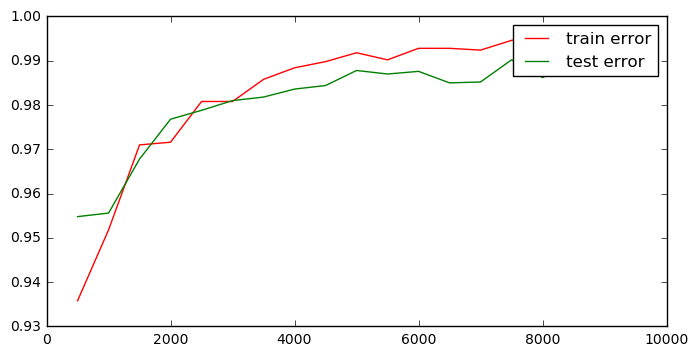

In [13]:
plt.figure(figsize=(8,4))
k=1
plt.plot(batch_iter[k:], train_error[k:], 'r', batch_iter[k:], test_error[k:], 'g');
plt.legend(["train error", "test error"]);